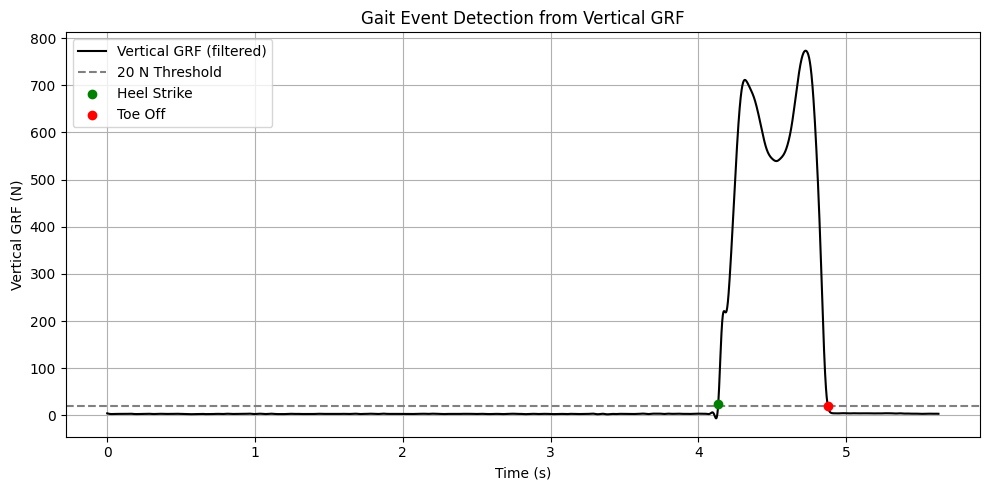

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

# ==============================
# USER INPUTS
# ==============================
grf_file = 'stw1.mot'   # your force plate file
fs = 1000                     # sampling frequency (Hz)
cutoff = 20                  # Butterworth cutoff frequency (Hz)
threshold = 20               # force threshold (N)
min_width = 15               # minimum width in samples

# ==============================
# READ OpenSim .sto FILE
# ==============================
with open(grf_file, 'r') as f:
    for i, line in enumerate(f):
        if 'endheader' in line.lower():
            header_line = i
            break

data = pd.read_csv(
    grf_file,
    sep=r'\s+',
    skiprows=header_line + 1
)

time = data['time'].values
vy_raw = data['ground_force_2_vy'].values  # vertical GRF

# ==============================
# BUTTERWORTH FILTER (zero-phase)
# ==============================
b, a = butter(
    N=4,
    Wn=cutoff / (fs / 2),
    btype='low'
)

vy_filt = filtfilt(b, a, vy_raw)

# ==============================
# GAIT EVENT DETECTION
# ==============================
above = vy_filt > threshold

HS_idx = []
TO_idx = []

i = 0
while i < len(above) - min_width:
    # Heel Strike: below → above threshold for >= min_width samples
    if not above[i] and all(above[i+1:i+1+min_width]):
        HS_idx.append(i + 1)
        i += min_width
        continue

    # Toe Off: above → below threshold for >= min_width samples
    if above[i] and all(~above[i+1:i+1+min_width]):
        TO_idx.append(i + 1)
        i += min_width
        continue

    i += 1

HS_times = time[HS_idx]
TO_times = time[TO_idx]

# ==============================
# PLOT
# ==============================
plt.figure(figsize=(10, 5))

plt.plot(time, vy_filt, label='Vertical GRF (filtered)', color='black')
plt.axhline(threshold, linestyle='--', color='gray', label='20 N Threshold')

plt.scatter(HS_times, vy_filt[HS_idx],
            color='green', label='Heel Strike', zorder=3)

plt.scatter(TO_times, vy_filt[TO_idx],
            color='red', label='Toe Off', zorder=3)

plt.xlabel('Time (s)')
plt.ylabel('Vertical GRF (N)')
plt.title('Gait Event Detection from Vertical GRF')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
